In [11]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from imgaug import augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [2]:
dataset_folder = "/content/drive/MyDrive/Stage/Stage Falcon/dataset"
augmented_folder = "/content/drive/MyDrive/Stage/Stage Falcon/Augmented_dataset"

In [3]:
augmentation_seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # horizontal flips
    iaa.Flipud(0.5),  # vertical flips
    iaa.Affine(rotate=(-45, 45)),  # random rotations
    iaa.Multiply((0.8, 1.2)),  # random brightness
    iaa.GammaContrast((0.7, 1.3))  # random contrast
    # Add more augmentation techniques as per your requirements
])

In [19]:
for filename in os.listdir(os.path.join(dataset_folder, "images")):
    if filename.endswith(".png"):
        image_path = os.path.join(dataset_folder, "images", filename)
        mask_path = os.path.join(dataset_folder, "masks", filename)
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if mask.ndim == 2:
          mask = np.expand_dims(mask, axis=-1)

        segmap = SegmentationMapsOnImage(mask, shape=image.shape)
        augmented_images, augmented_segmaps = augmentation_seq(image=image, segmentation_maps=segmap)

        for i, augmented_image in enumerate(augmented_images):
            augmented_image_path = os.path.join(augmented_folder, "images", f"{filename[:-4]}_{i}.png")
            augmented_mask_path = os.path.join(augmented_folder, "masks", f"{filename[:-4]}_{i}.png")

            cv2.imwrite(augmented_image_path, augmented_image)
            augmented_segmap = augmented_segmaps.draw_on_image(augmented_image)[0]
            cv2.imwrite(augmented_mask_path, augmented_segmap)

AssertionError: ignored

In [1]:
!nvidia-smi # confirm we have access to the GPU

Sun Jul  9 21:54:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [3]:
%cd {HOME}
# install SAM model
import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-3830k40w
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-3830k40w
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=6b9769c537251522cd9a69f78dba13fa183a2770f8d1699c7b0865e28725d35d
  Stored in directory: /tmp/pip-ephem-wheel-cache-8zf1v6de/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [4]:
# install external dependencies
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.3 MB/s eta 0:00:00


In [5]:
# download SAM weights
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [6]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))# confirm the file exists in the operating system

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [7]:
%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data

/content
/content/data


In [8]:
!wget -q /content/drive/MyDrive/Stage/Stage Falcon/dataset/images/W0001_0001.png

**Load Model**

In [9]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [10]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

**Automated Mask Generation**

In [11]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [12]:
import cv2
import supervision as sv

IMAGE_PATH='/content/drive/MyDrive/Stage/Stage Falcon/dataset/images/W0001_0001.png'
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

In [13]:
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [14]:
sam_result
# return a list of masks .
# each mask is represented by a dict
# segmentation key : boolean numpy array describing the mask
# area : int area of the mask in pixels
# bbox : list of int the bounding box of masks in xyzw format

[{'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 984821,
  'bbox': [9, 56, 3502, 305],
  'predicted_iou': 1.0085458755493164,
  'point_coords': [[3457.125, 165.84375]],
  'stability_score': 0.9742286205291748,
  'crop_box': [0, 0, 3512, 366]},
 {'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 260082,
  'bbox': [0, 0, 

In [18]:
print('number of masks :', len(sam_result))

number of masks : 7


**Results visualisation with Supervision**

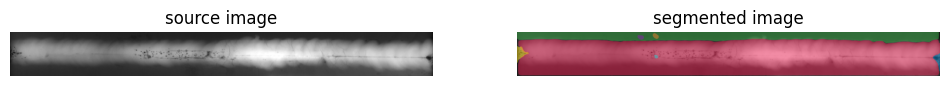

In [15]:
mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

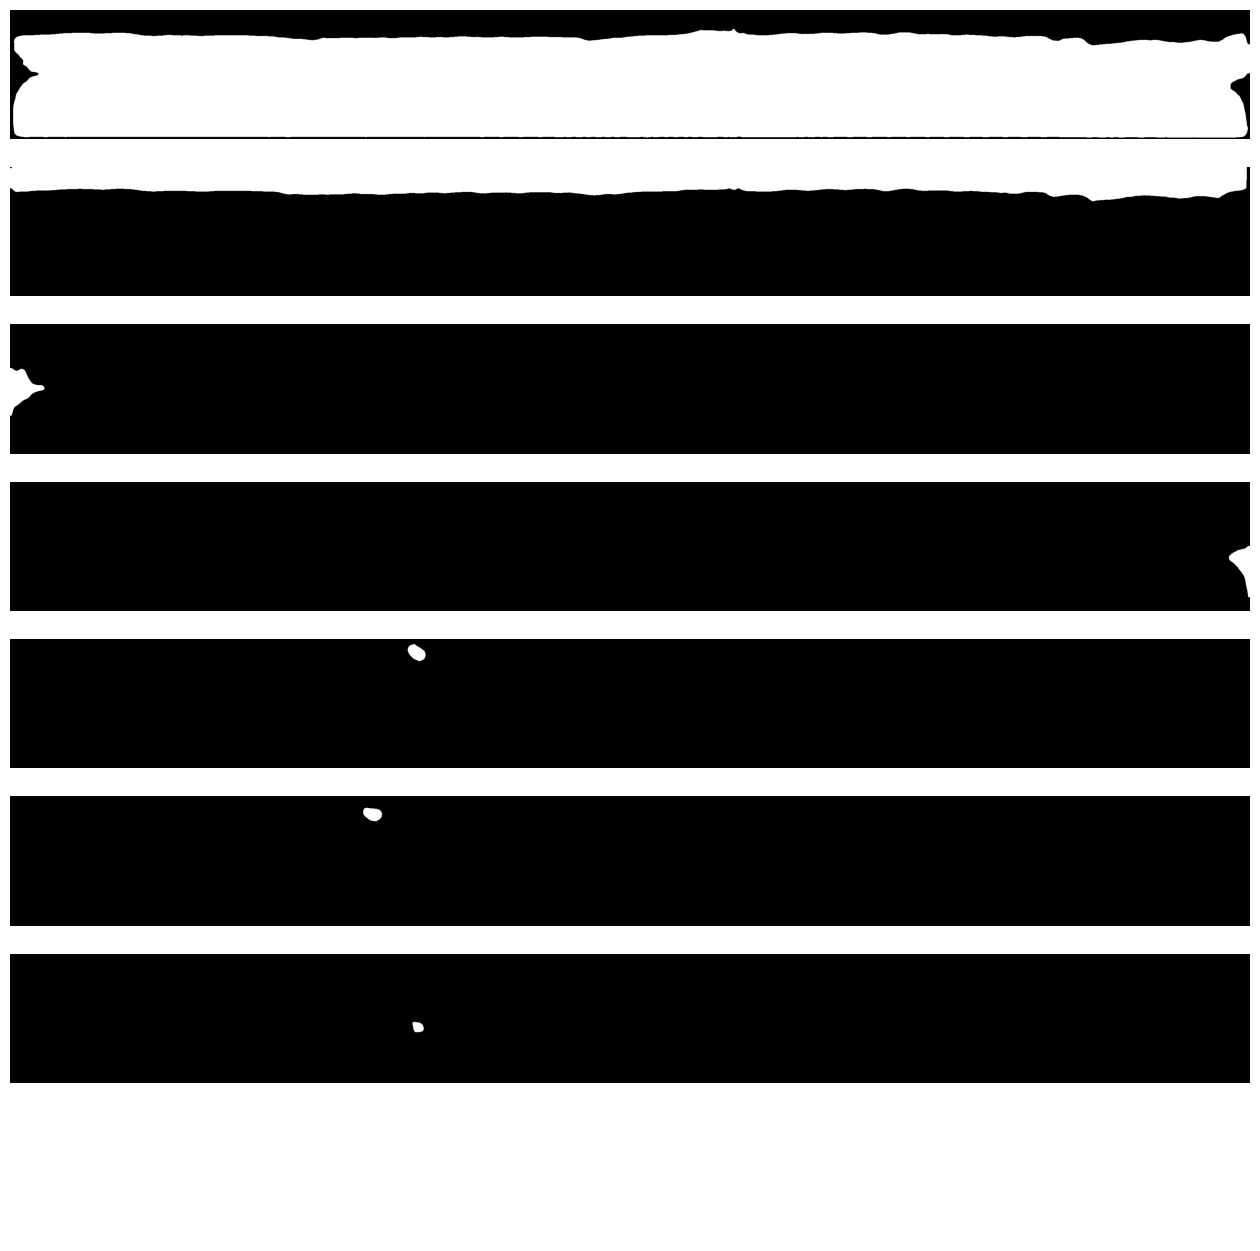

In [52]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)# sor ths masks by the area
]
sv.plot_images_grid(
    images=masks,
    grid_size=(8, int(len(masks) / 4)),
    size=(16, 16)
)
# we should add mask post processing and select the right strategy for use case
# we can try to merge mas with the largest IOU

**Generate Segmentation with Bounding Box**

In [105]:
mask_predictor = SamPredictor(sam)

In [106]:
# draw box
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [107]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [108]:
widget.bboxes

[{'x': 1004, 'y': 119, 'width': 896, 'height': 165, 'label': ''},
 {'x': 11, 'y': 83, 'width': 105, 'height': 176, 'label': ''},
 {'x': 2572, 'y': 132, 'width': 938, 'height': 144, 'label': ''}]

**Generate masks with SAM**

---

`SamPredictor.predict` method takes `np.ndarray` box argument in `[x_min, y_min, x_max, y_max]` format

In [109]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [110]:
import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)
# the output is a tuple of 3 elements

**Results visualisation with Supervision**

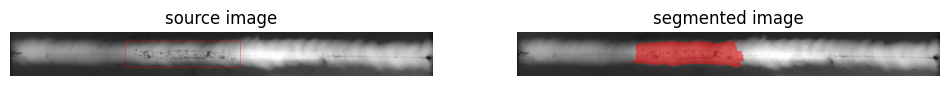

In [111]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

**Interaction with segmentation results**

In [112]:
print(len(masks))

3


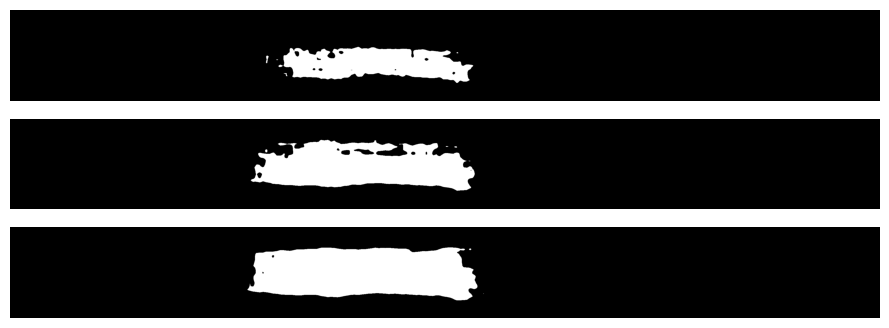

In [113]:
import supervision as v

sv.plot_images_grid(
    images=masks,
    grid_size=(3, 1),
    size=(16, 4)
)